In [1]:
import pickle as pkl
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import (
    model_selection,
    preprocessing,
    dummy,
    metrics,
    ensemble,
    tree,
    neighbors,
    pipeline,
    compose,
    linear_model,
    svm,
)
import xgboost as xgb


ROOT_DIR = Path.cwd().parent
MODEL_DIR = ROOT_DIR / "models"
ARTIFACT_DIR = MODEL_DIR / "artifacts"
warnings.filterwarnings("ignore")

In [2]:
CAT_COLS = [
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
]
NUM_COLS = ["tenure", "MonthlyCharges", "TotalCharges"]
TARGET = ["Churn"]
SEED = 69420

df = pd.read_csv(
    "../data/WA_Fn-UseC_-Telco-Customer-Churn.csv", usecols=CAT_COLS + NUM_COLS + TARGET
)
df.shape

(7043, 20)

In [3]:
CAT_COLS_OHE = ["PaymentMethod", "Contract", "InternetService"]
CAT_COLS_LE = list(set(CAT_COLS) - set(CAT_COLS_OHE))
CAT_COLS_LE

['OnlineSecurity',
 'MultipleLines',
 'Dependents',
 'DeviceProtection',
 'StreamingTV',
 'OnlineBackup',
 'gender',
 'SeniorCitizen',
 'PhoneService',
 'Partner',
 'PaperlessBilling',
 'StreamingMovies',
 'TechSupport']

In [4]:
df.TotalCharges = df.TotalCharges.replace(to_replace=" ", value="0")


def custom_combiner(feature, category):
    return str(feature) + "_" + type(category).__name__ + "_" + str(category)


scaler = preprocessing.StandardScaler().set_output(transform="pandas")
encoder_ohe = preprocessing.OneHotEncoder(feature_name_combiner=custom_combiner)
encoder_oe = preprocessing.OrdinalEncoder().set_output(transform="pandas")
target_encoder = preprocessing.LabelEncoder()

In [5]:
X, y = df.drop(columns=TARGET), df[TARGET]
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.1, random_state=42
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6338, 19), (705, 19), (6338, 1), (705, 1))

In [6]:
# One-hot encoding
X_ohe__train = X_train[CAT_COLS_OHE]
encoder_ohe.fit(X_ohe__train)
X_ohe_trans__train = encoder_ohe.transform(X_ohe__train)
X_ohe_trans_df__train: pd.DataFrame = pd.DataFrame(
    X_ohe_trans__train.toarray(), columns=encoder_ohe.get_feature_names_out()
)

print(X_ohe_trans__train.shape)

# Ordinal Encoding
X_oe__train = X_train[CAT_COLS_LE]
encoder_oe.fit(X_oe__train)
X_oe_trans__train = encoder_oe.transform(X_oe__train)
print(X_oe_trans__train.shape)

# Scale
X_scale__train = X_train[NUM_COLS]
scaler.fit(X_scale__train)
X_scale_trans__train = scaler.transform(X_scale__train)
print(X_scale_trans__train.shape)

X_to_train = pd.concat(
    [
        X_ohe_trans_df__train.reset_index(drop=True),
        X_oe_trans__train.reset_index(drop=True),
        X_scale_trans__train.reset_index(drop=True),
    ],
    axis=1,
)
print(X_to_train.shape)


# ----------------------------------------------- #
X_ohe__test = X_test[CAT_COLS_OHE]
X_ohe_trans__test = encoder_ohe.transform(X_ohe__test)
X_ohe_trans__test: pd.DataFrame = pd.DataFrame(
    X_ohe_trans__test.toarray(), columns=encoder_ohe.get_feature_names_out()
)

X_oe__test = X_test[CAT_COLS_LE]
X_oe_trans__test = encoder_oe.transform(X_oe__test)

X_scale__test = X_test[NUM_COLS]
scaler.fit(X_scale__test)
X_scale_trans__test = scaler.transform(X_scale__test)

X_to_test = pd.concat(
    [
        X_ohe_trans__test.reset_index(drop=True),
        X_oe_trans__test.reset_index(drop=True),
        X_scale_trans__test.reset_index(drop=True),
    ],
    axis=1,
)

# --------------------------------- #
# Encode target variable
target_encoder.fit(y_train)
y_train = target_encoder.transform(y_train)
y_test = target_encoder.transform(y_test)

# --------------------------------- #
# Saving the preprocessors
preprocessors_names = [
    "encoder_ohe_",
    "encoder_oe_",
    "scaler_standard_",
    "target_encoder_",
]
trained_processors = [encoder_ohe, encoder_oe, scaler, target_encoder]
for name, preprocessor in zip(preprocessors_names, trained_processors):
    path_ = ARTIFACT_DIR / f"{name}.pkl"
    with open(str(path_), "wb") as f:
        pkl.dump(preprocessor, f)

(6338, 10)
(6338, 13)
(6338, 3)
(6338, 26)


In [8]:
def run_experiments(
    models,
    X_train=X_to_train,
    y_train=y_train,
    X_test=X_to_test,
    y_test=y_test,
) -> pd.DataFrame:
    results = dict()
    for name, model in models:
        model.fit(X_train, y_train)
        path_ = MODEL_DIR / f"{name}.pkl"
        with open(path_, "wb") as f:
            pkl.dump(preprocessor, f)
        predictions = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, predictions)
        precision, recall, fscore, _ = metrics.precision_recall_fscore_support(
            y_test, predictions, average="weighted"
        )
        print(f"{name} --> {fscore}")
        results[name] = (accuracy, precision, recall, fscore)
    return pd.DataFrame.from_dict(results)


models = [
    (
        "dummy_classifier",
        dummy.DummyClassifier(random_state=SEED, strategy="most_frequent"),
    ),
    ("k_nearest_neighbors", neighbors.KNeighborsClassifier()),
    (
        "logistic_regression",
        linear_model.LogisticRegression(
            random_state=SEED, solver="liblinear", class_weight="balanced"
        ),
    ),
    ("support_vector_machines", svm.SVC(random_state=SEED, kernel="rbf")),
    ("random_forest", ensemble.RandomForestClassifier(random_state=SEED)),
    ("gradient_boosting", ensemble.GradientBoostingClassifier(random_state=SEED)),
    ("decision_tree", tree.DecisionTreeClassifier(random_state=SEED)),
    ("adaboost", ensemble.AdaBoostClassifier()),
    (
        "voting",
        ensemble.VotingClassifier(
            estimators=[
                ("gbc", ensemble.GradientBoostingClassifier()),
                ("lr", linear_model.LogisticRegression()),
                ("abc", ensemble.AdaBoostClassifier()),
            ],
            voting="soft",
        ),
    ),
    ("xgb", xgb.XGBClassifier()),
]

results = run_experiments(
    models=models,
    X_train=X_to_train.to_numpy(),
    y_train=y_train,
    X_test=X_to_test.to_numpy(),
    y_test=y_test,
)
results = results.T
results.columns = ["accuracy", "precision", "recall", "fscore"]
results = results.sort_values(by=["fscore"], ascending=False)
results

dummy_classifier --> 0.6091848637551326
k_nearest_neighbors --> 0.7665209624344095
logistic_regression --> 0.7719935446908444
support_vector_machines --> 0.8005851403468898
random_forest --> 0.7908593842862237
gradient_boosting --> 0.8025849518643331
decision_tree --> 0.7076461754558577
adaboost --> 0.7962382434995371
voting --> 0.8055296519799785


,accuracy,precision,recall,fscore
voting,0.811348,0.803952,0.811348,0.805530
gradient_boosting,0.809929,0.801572,0.809929,0.802585
support_vector_machines,0.811348,0.802415,0.811348,0.800585
adaboost,0.804255,0.795138,0.804255,0.796238
random_forest,0.801418,0.791141,0.801418,0.790859
logistic_regression,0.760284,0.815368,0.760284,0.771994
k_nearest_neighbors,0.774468,0.763462,0.774468,0.766521
decision_tree,0.719149,0.701505,0.719149,0.707646
dummy_classifier,0.724823,0.525368,0.724823,0.609185


<Axes: >

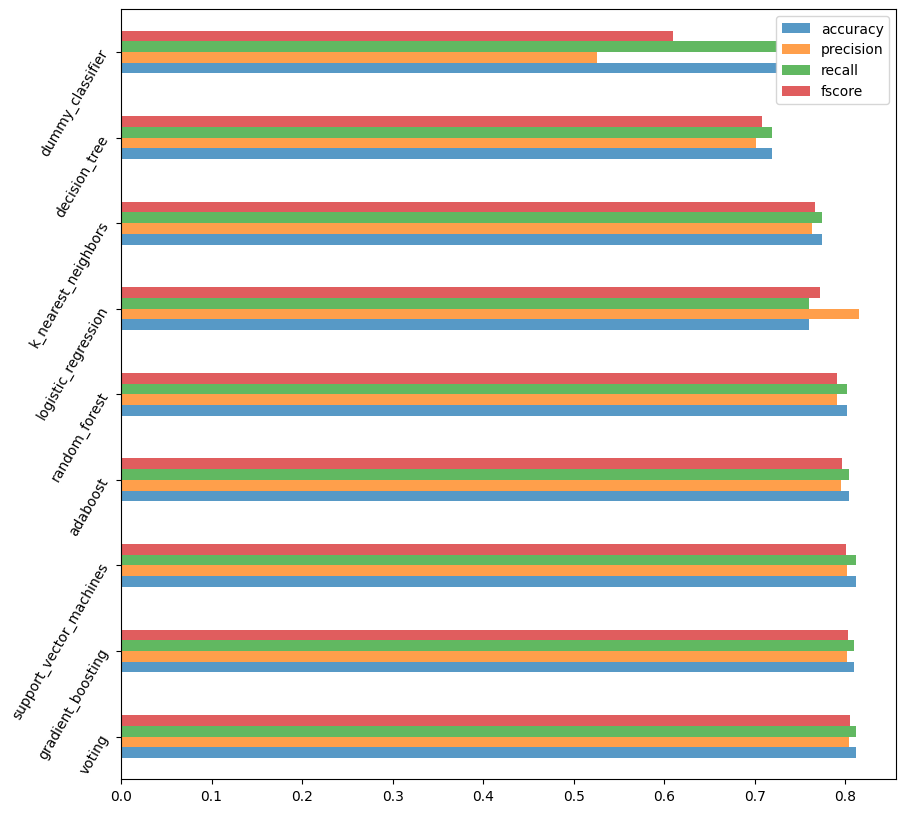

In [9]:
results.plot(kind="barh", figsize=(10, 10), alpha=0.75, rot=60, ylim=(0, 1))